In [ ]:
import sys
sys.path.append("../src")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys, copy, time
from typing import Callable, List, Tuple
from IPython.display import clear_output, display

import gc

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from tqdm.notebook import tqdm

from dataloaders.dataloader import Dataloader4InverseModel
from utils.task_utils import Num_GPU_Usage
from inverse_optimization.inv_opt import IV_Model, ForwardModelFreezeCallback
from exp_scripts.scripts_utils import ReflectExpCondition2config
from utils.config import cfg_add_dirs
from simulators.stack import Stack_task_simulator
from simulators.shell import Shell_task_simulator
from eval.evaluation import ResimError, AMD_resim_body


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def show_graph(iv_model):
    candidate_loss_history = np.array(iv_model.proj_net.candidate_loss_history)
    candidate_loss_history  = pd.DataFrame(candidate_loss_history).fillna(method='bfill').values
    candidate_index = list(iv_model.proj_net.candidate_index.detach().cpu().numpy())
    dist_loss_history = np.array(iv_model.proj_net.dist_loss_history)
    dist_srt_step = np.isnan(np.sum(dist_loss_history,axis=1)).sum()
    dist_can_history = np.array(iv_model.proj_net.dist_can_history)
    print("dist_can_history.shape:",dist_can_history.shape)

    good_cand_index = 0
    cand_color = {}
    for ci in range(iv_model.proj_net.num_cand):
        if ci in candidate_index:
            plt.plot(candidate_loss_history[:dist_srt_step,ci],c=line_colors(good_cand_index))
            cand_color[ci] = line_colors(good_cand_index)
            good_cand_index+=1

        else:
            plt.plot(candidate_loss_history[:dist_srt_step,ci], c='grey',alpha=0.2)
    for i in range(iv_model.proj_net.num_branch):
        ci = int(dist_can_history[-1, i])
        c = cand_color[ci]
        plt.plot(dist_loss_history[:,i],c=c)        

    plt.xlabel('steps')    
    plt.ylabel('loss (log scale)')
    plt.show()

In [5]:
def InverseOptimization(
    config_path: str,
    signal_id: int,
    trial_id: int,
    method: str,
    params_dic: dict,
    num_sampling: int,
    candidate_display: bool = True,
    no_eval: bool = False,
    sort_candidate: bool = True,
):
    """solving the inverse problem
    Args:
        config_path(str):config path
        signal_id(int): a target signal (spectrum) for the inverse problem
        trial_id(int): trial ID for a same target signal
        params_dic(dict): parameter setting dictionary
        num_sampling(int): how many candidates to eval
        candidate_display(bool): show the optimization history (only for Neural Lagrangian)
        no_eval(bool): skip evaluation with ground truth simulator
        sort(bool): use sampling sorting based on surrogate simulator loss


    """

    condition_dict = {
        "condition_type": None,
        "trial_id": trial_id,
        "target_id": signal_id,
        "iv_batch_size": params_dic["iv_batch_size"],
    }
    cfg, constrain_name = ReflectExpCondition2config(
        config_path, method, False, condition_dict
    )

    cfg_add_dirs(cfg)

    # 実験ディレクトリを指定する
    cfg.output_dirs.result_dir = "./tmp_results"
    os.makedirs(cfg.output_dirs.result_dir, exist_ok=True)

    iv_batch_size = cfg.inverse_problem.method_parameters.iv_batch_size

    # Settings of candidate reduction
    if cfg.inverse_problem.method == "NeuralLagrangian":
        reduction_schedule = cfg.inverse_problem.proj.reduction_schedule
        opt_steps = cfg.inverse_problem.method_parameters.optimization_steps
        if len(reduction_schedule) == 0:
            cfg.inverse_problem.proj.use_candidate_selection = False
            max_epochs = 1
            cfg.inverse_problem.method_parameters.optimization_steps = opt_steps
        else:
            cfg.inverse_problem.proj.use_candidate_selection = True
            cfg.inverse_problem.method_parameters.optimization_steps = opt_steps // len(
                reduction_schedule
            )
            max_epochs = len(reduction_schedule)
    elif cfg.inverse_problem.method == "NA":
        max_epochs = 1

    # Solving inverse problem
    iv_batch_size = cfg.inverse_problem.method_parameters.iv_batch_size
    test_loader, targets = Dataloader4InverseModel(cfg)

    # dataloader for sampling
    sampling_cfg = copy.deepcopy(cfg)
    num_batch = int(np.ceil(num_sampling / iv_batch_size))
    sampling_cfg.inverse_problem.method_parameters.optimization_steps = num_batch
    sampling_loader, _ = Dataloader4InverseModel(sampling_cfg)

    # inverse optimization
    iv_model = IV_Model(cfg)
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=Num_GPU_Usage(),
        gradient_clip_val=cfg.inverse_problem.method_parameters.grad_clip,
        callbacks=[ForwardModelFreezeCallback()],
    )
    srt = time.time()
    trainer.fit(iv_model, train_dataloaders=test_loader)
    train_time = time.time() - srt


    # candidate display
    if candidate_display:
        print("eval")
        candidate_loss_history = np.array(iv_model.proj_net.candidate_loss_history)
        candidate_loss_history = (
            pd.DataFrame(candidate_loss_history).fillna(method="bfill").values
        )
        for i in range(iv_model.proj_net.num_cand):
            plt.plot(candidate_loss_history[:, i])
        plt.xlabel("steps")
        plt.ylabel("loss (log scale)")
        plt.show()
        if method == 'NeuralLagrangian':
            show_graph(iv_model)
    else:
        candidate_loss_history = None

    
    if no_eval:
        # clean up gpu memory
        del iv_model, trainer, sampling_loader
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()
        time_dict = {"train_time": train_time}
        return None, None, None, None, None, time_dict

    # sampling and sort
    srt = time.time()
    sampling_results = trainer.predict(dataloaders=sampling_loader)
    opt_input = (
        torch.concat([result[0] for result in sampling_results], dim=0).cpu().numpy()
    )
    loss_result = (
        torch.concat([result[1] for result in sampling_results], dim=0).cpu().numpy()
    )
    sampling_time = time.time() - srt

    time_dict = {
        "train_time": train_time,
        "sampling_time": sampling_time,
    }
    y_gt = iv_model.y_gt.detach().cpu().numpy()[:1]

    # メモリの整理
    del iv_model, trainer, sampling_loader
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()

    return candidate_loss_history, opt_input, loss_result, y_gt, cfg, time_dict

In [6]:
def line_colors(i):
    cs = [
        'tab:blue',
        'tab:orange',
        'tab:green',
        'tab:red',
        'tab:purple',
        'tab:cyan',
        'tab:pink',
        'tab:olive'
    ]
    i = i%len(cs)
    return cs[i]

def linestyles(i):
    lses = [
        'solid',
        'dotted',
        'dashed',
        'dashdot'
    ]
    i=i%len(lses)
    return lses[i]

In [8]:
task = 'Stack'
model_name = 'medium'
num_trial = 1
num_sampling = 128

nl_config_path = f"../workspace/configs/sampling_speed/SS_NeuralLagrangian_{task}_{model_name}-model_config.yaml"
na_config_path = f"../workspace/configs/sampling_speed/SS_NA_{task}_{model_name}-model_config.yaml"

signal_id, trial_id, method = 0, 0, 0

params_dic = {'iv_batch_size':16}

# Neural Lagrangian

-------------------------------------
  Stack - NeuralLagrangian  |  ID-0_No-constrain__medium-model_trial-0__-16batch
-------------------------------------
<info> Projector proj_noise:True, noise_scale:0.001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                     | Params
--------------------------------------------------------
0 | fw_model   | BiggerSurrogateSimulator | 14.2 M
1 | proj_net   | Projector                | 420 K 
2 | bloss_func | BoundaryLossModel        | 10    
--------------------------------------------------------
14.7 M    Trainable params
11        Non-trainable params
14.7 M    Total params
58.600    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

num candidate index 128 ->4
<INFO> branching candidate starts.
<INFO> No candidate selection


`Trainer.fit` stopped: `max_epochs=2` reached.


eval


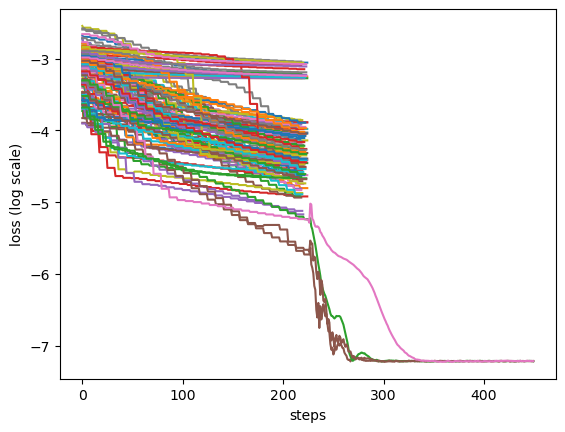

dist_can_history.shape: (450, 16)


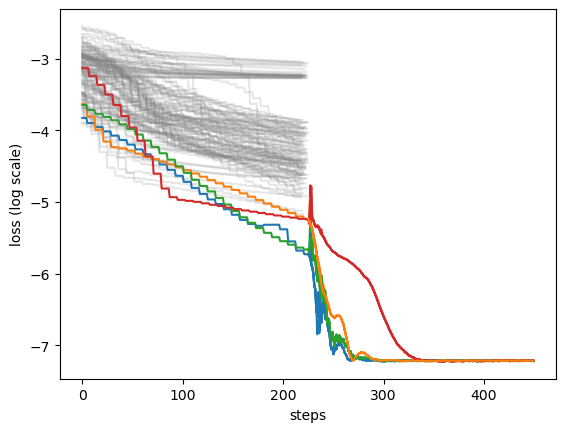

Restoring states from the checkpoint path at /home/afujii/awesome_physics_project/notebooks/lightning_logs/version_25773/checkpoints/epoch=1-step=450.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /home/afujii/awesome_physics_project/notebooks/lightning_logs/version_25773/checkpoints/epoch=1-step=450.ckpt


Predicting: 225it [00:00, ?it/s]

In [15]:
_ = InverseOptimization(
    nl_config_path,
    signal_id,
    trial_id,
    'NeuralLagrangian',
    params_dic,
    num_sampling,
    True
)

# NA method

-------------------------------------
  Stack - NA  |  ID-0_No-constrain__medium-model_trial-0__-16batch
-------------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                     | Params
--------------------------------------------------------
0 | fw_model   | BiggerSurrogateSimulator | 14.2 M
1 | proj_net   | Projector                | 0     
2 | bloss_func | BoundaryLossModel        | 10    
--------------------------------------------------------
14.2 M    Trainable params
267       Non-trainable params
14.2 M    Total params
56.921    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


eval


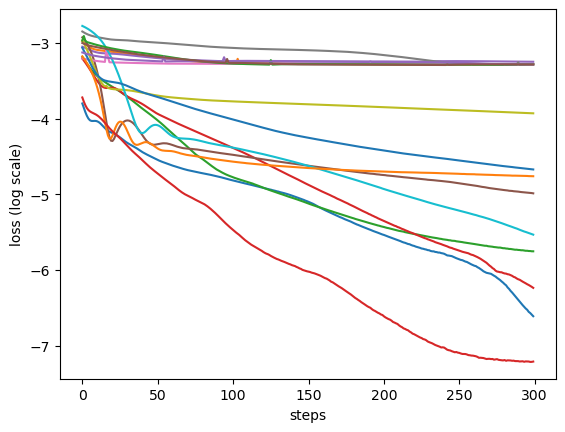

Restoring states from the checkpoint path at /home/afujii/awesome_physics_project/notebooks/lightning_logs/version_25772/checkpoints/epoch=0-step=300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /home/afujii/awesome_physics_project/notebooks/lightning_logs/version_25772/checkpoints/epoch=0-step=300.ckpt


Predicting: 300it [00:00, ?it/s]

In [14]:
_ = InverseOptimization(
    na_config_path,
    signal_id,
    trial_id,
    'NA',
    params_dic,
    num_sampling,
    True
)